<a href="https://colab.research.google.com/github/eloreaux/Exploring-and-Predicting-Traffic-Fatalities/blob/master/traffic_fatalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration of NHTSA Traffic Fatalities Data - 2016

### By Eric Loreaux

## Setting up BigQuery and Dependencies

In [0]:
# Run this cell to authenticate to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "superb-metric-200303"

In [0]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [0]:
!pip install matplotlib --upgrade

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.0.2)


In [0]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import numpy as np

plt.style.use('seaborn-whitegrid')

## Analysis of Dataset

In this analysis, we will be exploring recorded traffic accidents for the year 2016 that resulted in fatalities. Data on these accidents is collected by the US National Highway Traffic Safety Administration (NHTSA). This data is comprised of three main tables representing unique accidents and the vehicles and persons involved in these accidents. Beyond these three core tables are a number of smaller tables containing additional information such as contributing circumstances, any violations charged to individuals involved, and maneuvers performed by the drivers.

Below are the tuple counts and normal forms for all tables:
- accident (main table for all accidents) - 34,748
- vehicle (vehicles involved in accidents) - 52,714
- person (persons involved in accidents) - 86,474
- vevent (vehicular events related to accidents) - 123,132
- safetyeq (safety equipment used by persons) - 7,695
- damage (damage sustained by vehicles in accidents) - 214,891
- vision (vision obscuring factors in accidents) - 52,757
- violatn (violations charged to vehicles in accidents) - 55,927
- distract (conditions of distraction for drivers in accidents) - 52,757
- drimpair (impairments of drivers in accidents) - 52,929
- nmimpair (impairments of non-motorists in accidents) - 7,692
- nmcrash (contributing circumstances by non-motorists in accidents) - 9,836
- maneuver (attempts by drivers to maneuver during accidents) - 52,726
    
Below is a schema I created of the most relevant tables for this analysis:

![dksjd](https://drive.google.com/uc?export=view&id=1rgC2i6NO0BHS2F6WMVoidkfKZiACLrr3)

Upon inspection, there are a number of design choices made with this dataset that introduce significant number of storage inefficiencies that are worth discussing. These are outlined below:

### Keys

The `consecutive_number` is the key for the main Accident table, and appears as a foreign key in all other tables. The other two keys that show up as foreign keys are `vehicle_number` and `person_number`, appearing as part of the primary keys in the Vehicle and Person tables, respectively.  Interestingly, the choice was made to not make these keys sufficient primary keys. Instead, only in combination with `consecutive_number` do these keys contain all other columns in their closures. To see this in practice, consider an accident in which two vehicles are involved. A unique `consecutive_number` is assigned to this accident, however the vehicles will be assigned `vehicle_number` values of 1 and 2, so that they are unique only within the context of this accident. This increases the storage needs of the dataset, in which smaller tables need to include foreign keys for tables once or twice removed. Concatenating keys in order to obtain a single unique key column is a partial solution, although it still fails to ensure a constant size of the key string (a problem that persists for any keys generated from a simple counting of tuples, as is the case here).

### Normalization

#### 1NF
The dataset almost perfectly adheres to the first normal form, with only one table (Vevent) having one duplicate row, which is negligible.
#### 2NF
Other than the main Accident table, no other tables in this dataset fully adhere to the second normal from. The primary reason is that all tables include some sort of categorical indicator, and these indicators come in a numeric code form and a corresponding english name form. The result is a partial dependency by the english name form on a column of the primary key (the code form), and therefore a violation of 2NF. Storage could be saved and consistency could be improved by having separate smaller tables that mapped these codes to the english name versions. In addition, `state_number` appears in almost every table, despite depending only on consecutive number.
#### 3NF
The main Accident table, which up to this point remained in adherence to normalization forms, violates 3NF. A timestamp column is depended upon by day, month, hour, & minute columns and a series of indicator codes are depended upon by their english name counterparts.

### Redundant Information

There is a large amount of redundant information contained in these data tables. All three large tables (Accident, Vehicle, Person) include timestamp information, and every single table in the whole dataset includes a number for the state that the accident occured in. These redundancies increase the clunkiness and data storage needs of the system, and make it difficult to develop rapid approaches for extracting data efficiently.

### Tradeoffs

Despite the normalization violations and redundancies found in this dataset, there are benefits to the data management decisions made by the NHTSA. For one, simple targeted questions can be answered much more efficiently without needing to coordinate a large number of joins. For example, almost all summary information on indicator features can be exported in english-readable format without having to join a code-to-english table map every time. Timestamp and location data can be plotted or summarized at the accident-, vehicle-, or person-level without having to traverse multiple tables to find it. These decreases in query complexity are counterbalanced with increases in general storage size and the potential for inconsistencies to arise through data anomalies when entering new data or changing existing relationships.


   


## Questions to Explore
In this section of the analysis, I will answer a series of questions with data visualizations to better understand the relationships between variables. Primarily, my questions will revolve around a singular theme: how do the outcomes of these traffic accidents depend on the environmental factors and events that took place? This will provide more insights into the data available and help me identify new ways in which situational traffic accident information could be used to predict the ultimate consequences - who lives and who dies?

### 'Deadliness' Metric

In many of the following visualizations, I will be answering questions about the relationships between environmental accident factors and 'deadliness.' As a proxy for deadliness, I take the total number of fatalities in accidents with certain environment factors and divide by the total number of vehicle occupents involved in those same accidents. This effectively serves as the percentage chance that an individual involved in one of these accidents does not survive.

### How does time affect number of fatalities?
It makes sense that time of year or time of day may have an impact on the deadliness of traffic accidents. Different seasons bring different driving conditions, and different hours lead to different conditions and mindsets of drivers on the road.

#### Month

In [0]:
%%bigquery --project superb-metric-200303 crash_month_2016

SELECT a.month_of_crash, sum( v.fatalities_in_vehicle ) / sum( v.number_of_occupants ) deadliness, count(*) total_vehicles
FROM `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` v,
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a
WHERE v.consecutive_number = a.consecutive_number
GROUP BY month_of_crash
ORDER BY month_of_crash

,month_of_crash,deadliness,total_vehicles
0,1,0.273028,3483
1,2,0.299029,3668
2,3,0.302331,4065
3,4,0.290786,4172
4,5,0.308074,4580
5,6,0.285874,4721
6,7,0.301744,4583
7,8,0.286115,4794
8,9,0.271183,4758
9,10,0.268143,4933


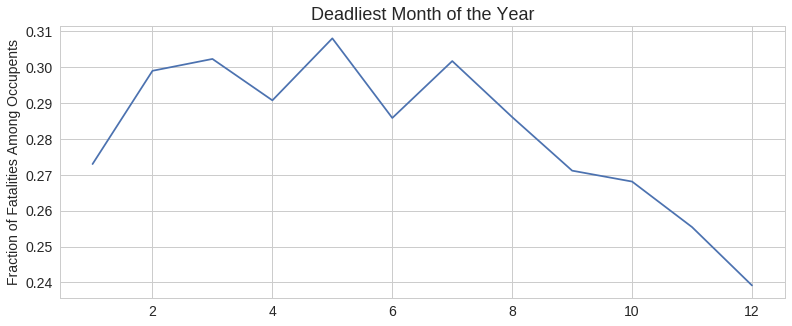

In [0]:

fig = plt.figure(figsize = (13, 5))

plt.plot(crash_month_2016["month_of_crash"], crash_month_2016["deadliness"])
ax = fig.gca()

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.ylabel("Fraction of Fatalities Among Occupents", fontsize = 14)
plt.title("Deadliest Month of the Year", fontsize = 18)
plt.show()

Initially, my hypothesis was that the deadliness of traffic accidents in the US would reach their peak in the winter months, where road conditions are at their worst in large swaths of the country. This hypothesis proved to be correct, although unexpectedly, the deadliness does not decrease until the late Summer. There is no clear explanation for why Autumn is the safest season for driving.

#### Hour

In [0]:
%%bigquery --project superb-metric-200303 crash_hour_2016

SELECT a.hour_of_crash, sum( v.fatalities_in_vehicle ) / sum( v.number_of_occupants ) deadliness, count(*) total_vehicles
FROM `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` v,
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a
WHERE v.consecutive_number = a.consecutive_number
AND a.hour_of_crash < 99
GROUP BY a.hour_of_crash
ORDER BY a.hour_of_crash

,hour_of_crash,deadliness,total_vehicles
0,0,0.280735,1764
1,1,0.281928,1679
2,2,0.315048,1792
3,3,0.245936,1366
4,4,0.257624,1139
5,5,0.260082,1691
6,6,0.268381,1929
7,7,0.322806,1843
8,8,0.350924,1590
9,9,0.359033,1688


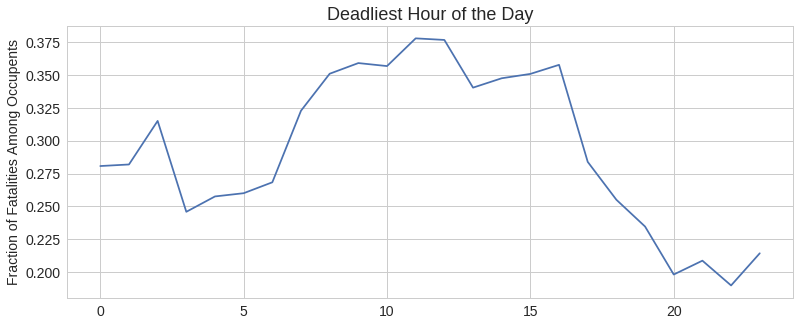

In [0]:
fig = plt.figure(figsize = (13, 5))

plt.plot(crash_hour_2016["hour_of_crash"], crash_hour_2016["deadliness"])
ax = fig.gca()

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.ylabel("Fraction of Fatalities Among Occupents", fontsize = 14)
plt.title("Deadliest Hour of the Day", fontsize = 18)
plt.show()

My initial hypothesis was that nighttime would be the deadlier part of the day, due to more drunk driving and worse visibility conditions. It turns out that peak traffic hours are actually much deadlier. My new working hypothesis is that the daylight  causes people to driver faster and more recklessly because they feel less cautious given perfect visibility on the road. In addition, with more vehicles on the road, there is more potential for reckless decisions to lead to fatal accidents.

### What are the deadliest environmental conditions for motorists?
Environmental conditions certainly play a role in the safety of motorists. Some conditions can make it much more difficult to avoid dangerous circumstances leading to even more dangerous collisions.


In [0]:
%%bigquery --project superb-metric-200303 atmospheric_deadliness

SELECT a.atmospheric_conditions_name, sum( v.fatalities_in_vehicle ) / sum( v.number_of_occupants ) deadliness, count(*) total_vehicles
FROM `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` v,
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a
WHERE v.consecutive_number = a.consecutive_number
GROUP BY atmospheric_conditions_name
ORDER BY deadliness DESC

,atmospheric_conditions_name,deadliness,total_vehicles
0,Other,0.500000,71
1,Blowing Snow,0.482759,20
2,Severe Crosswinds,0.471698,66
3,Freezing Rain or Drizzle,0.437500,25
4,"Sleet, Hail",0.391892,99
5,"Blowing Sand, Soil, Dirt",0.296875,36
6,"Fog, Smog, Smoke",0.294118,497
7,Rain,0.287822,3243
8,Cloudy,0.285244,7727
9,Clear,0.282007,37841


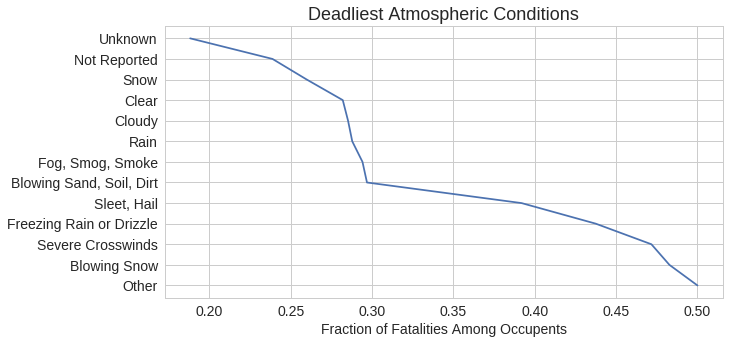

In [0]:
fig = plt.figure(figsize = (10, 5))

plt.plot(atmospheric_deadliness["deadliness"], atmospheric_deadliness["atmospheric_conditions_name"])
ax = fig.gca()

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.xlabel("Fraction of Fatalities Among Occupents", fontsize = 14)
plt.title("Deadliest Atmospheric Conditions", fontsize = 18)
plt.show()

These results mostly fit in line with what I would have expected: severe weather conditions lead to deadlier accidents. The only known weather condition with traffic accidents that are less deadly than perfect weather conditions is snow. I would imagine the reason for this is that drivers tend to drive much more slowly in this weather than they normally would, leading to accidents of a less severe nature. This hypothesis in isolation could also justify a scenario in which all severe weather conditions result in lower deadliness than clear days, however, which is not the case. Snow seems to be different. I would argue that in these other weather conditions, visibility also plays a major role, which would also contribute to deadliness.

### What are the deadliest types of streets?
The US is full of different types of roads, which some experiencing heavy and fast traffic and others spanning many lanes. Here we investigate what sort of roads contain the deadliest traffic accidents.

In [0]:
%%bigquery --project superb-metric-200303 street_deadliness

SELECT a.route_signing_name, sum( v.fatalities_in_vehicle ) / sum( v.number_of_occupants ) deadliness, count(*) total_vehicles
FROM `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` v,
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a
WHERE v.consecutive_number = a.consecutive_number
GROUP BY a.route_signing_name
ORDER BY deadliness DESC

,route_signing_name,deadliness,total_vehicles
0,County Road,0.382194,7027
1,State Highway,0.342417,16125
2,U.S. Highway,0.320188,9270
3,Local Street – Township,0.307749,2039
4,Interstate,0.292400,7203
5,Unknown,0.176972,111
6,Local Street – Municipality,0.167945,8926
7,Other,0.167855,1592
8,Local Street – Frontage Road (Since 1994),0.114035,421


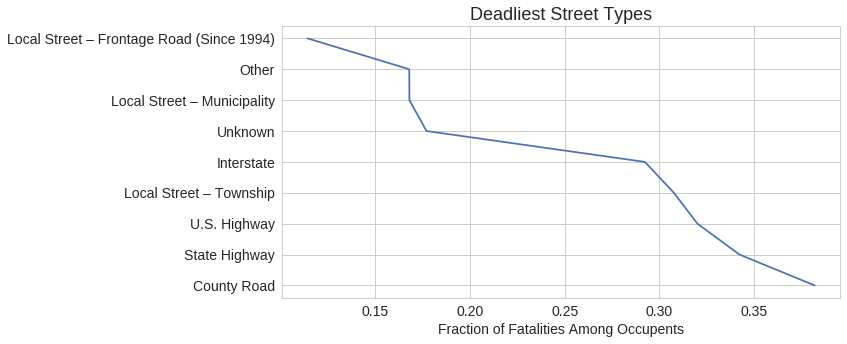

In [0]:
fig = plt.figure(figsize = (10, 5))

plt.plot(street_deadliness["deadliness"], street_deadliness["route_signing_name"])
ax = fig.gca()

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.xlabel("Fraction of Fatalities Among Occupents", fontsize = 14)
plt.title("Deadliest Street Types", fontsize = 18)
plt.show()

This was a really interesting relationship to uncover. I would have initially thought that highways would undoubtedly be the deadliest roads in the US, since drivers are moving at the fastest speeds and oftentimes exhibiting the lowest environmental awareness. It turns out, however, that county roads are the deadliest roads in America - by far. My reaction was that drunk drivers may be accounting for this discrepancy, so I explored that relationship as well: 

In [0]:
%%bigquery --project superb-metric-200303 street_drinking

SELECT route_signing_name, (drinking *100 / total) AS drinking_perc, (nondrinking * 100 / total) AS nondrinking_perc
FROM (SELECT a.route_signing_name,(sum(IF(v.driver_drinking = "Drinking", 1, 0))) drinking, (sum(IF(v.driver_drinking = "Drinking", 0, 1))) nondrinking, count(*) total
FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a,
  `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` v
WHERE a.consecutive_number = v.consecutive_number
GROUP BY a.route_signing_name)
ORDER BY drinking_perc



,route_signing_name,drinking_perc,nondrinking_perc
0,U.S. Highway,13.581446,86.418554
1,Interstate,15.438012,84.561988
2,State Highway,16.862016,83.137984
3,Other,19.283920,80.716080
4,Local Street – Municipality,19.874524,80.125476
5,Local Street – Frontage Road (Since 1994),19.952494,80.047506
6,Local Street – Township,22.069642,77.930358
7,County Road,26.255870,73.744130
8,Unknown,29.729730,70.270270


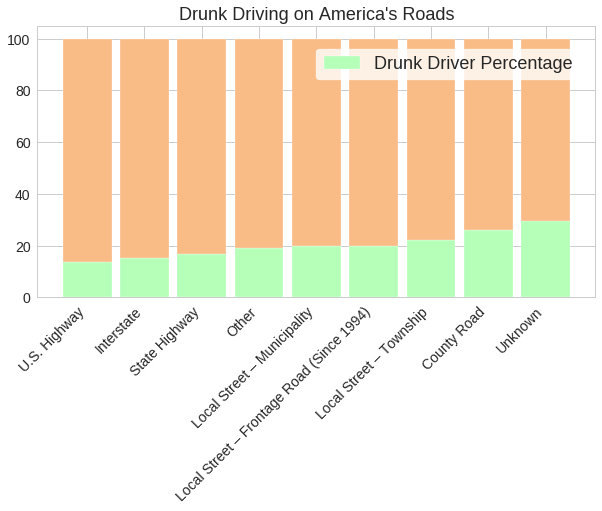

In [0]:
barWidth = 0.85

fig = plt.figure(figsize = (10, 5))
ax = fig.gca()

plt.bar(street_drinking["route_signing_name"], street_drinking["drinking_perc"], color='#b5ffb9', edgecolor='white', width=barWidth, label = "Drunk Driver Percentage")
plt.bar(street_drinking["route_signing_name"], street_drinking["nondrinking_perc"], bottom=street_drinking["drinking_perc"], color='#f9bc86', edgecolor='white', width=barWidth)
legend = plt.legend(frameon = 1, loc = (.5,.8), fontsize = 18)
frame = legend.get_frame()
frame.set_color('white')
plt.xticks(rotation = 45, fontsize = 14, ha = "right")
plt.yticks(fontsize = 14)

plt.title("Drunk Driving on America's Roads", fontsize = 18)
plt.show()




It turns out that County Roads do mark highest of all know road types in terms of drunk driving, but it remains unclear whether this distinction is sufficient enough to account for the difference in deadliness of traffic accidents.

### What is the deadliest object to collide with in a car?
Most traffic accidents occur when a motorist strikes an object, causing damage. The amount of damage caused and the consequences of that collision wholely depend on what sort of object was struck. Was it something soft and pliable or something so rigid that it won't budge an inch?

In [0]:
%%bigquery --project superb-metric-200303 collision_deadliness

SELECT a.first_harmful_event_name, sum( v.fatalities_in_vehicle ) / sum( v.number_of_occupants ) deadliness, count(*) total_vehicles
FROM `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` v,
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a
WHERE v.consecutive_number = a.consecutive_number
GROUP BY a.first_harmful_event_name
HAVING total_vehicles > 100
ORDER BY deadliness DESC

,first_harmful_event_name,deadliness,total_vehicles
0,Railway Vehicle,0.820513,104
1,Bridge Pier or Support,0.748503,119
2,Culvert,0.730882,482
3,Tree (Standing Only),0.711094,2571
4,Fence,0.710407,441
5,Ditch,0.699374,981
6,Wall,0.692308,108
7,Mail Box,0.688608,279
8,Ground,0.688312,104
9,"Other Post, Other Pole, or Other Support",0.683377,254


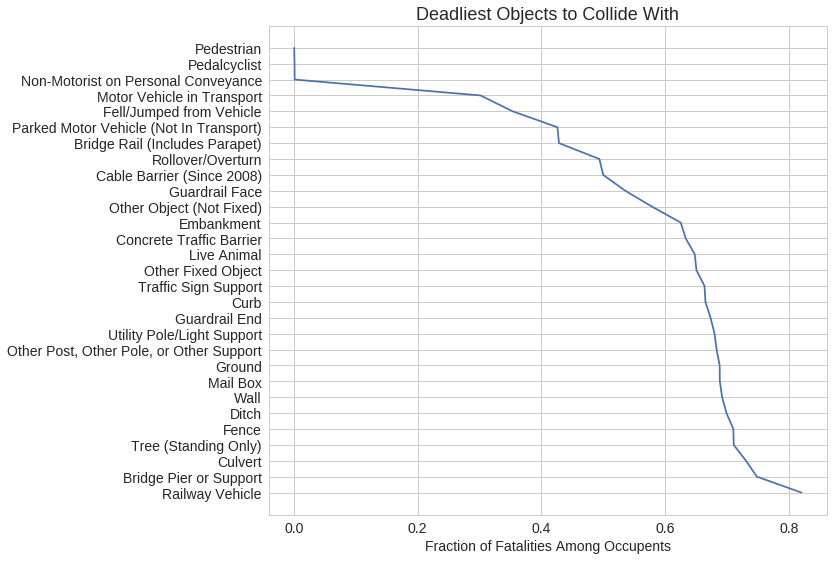

In [0]:
fig = plt.figure(figsize = (10, 9))

plt.plot(collision_deadliness["deadliness"], collision_deadliness["first_harmful_event_name"])
ax = fig.gca()

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.xlabel("Fraction of Fatalities Among Occupents", fontsize = 14)
plt.title("Deadliest Objects to Collide With", fontsize = 18)
plt.show()

This analysis was both interesting and darkly entertaining. As one moves through the list of relevant collision objects, one can imagine why each object has earned its spot on the list of deadliest objects to collide with. Unsurprisingly, few who collide with a train live to tell the tail. A car has no business being near a bridge pier or support, and so it follows naturally that in order to be near one, a car must find itself in severe circumstances. The same goes for a culvert, which after some googling I determined to be the subterranean, pipelike object that allows water to pass under roadways. Unsurprisingly, pedestrians and pedalcyclists are the safest objects for a driver to collide with because of their small inertia compared to some of the bigger and more cumbersome objects one could crash into. Therefore, my analysis concludes that if drivers want to stay alive, they should aim for pedestrians!

### What are the deadliest types of collisions ?
Colliding with an object isn't everything. The deadliness of the collision also depends on what sort of collision took place. How did the two objects come into contact, and which direction was their kinetic energy devoted to before sharing that energy with each other?

In [0]:
%%bigquery --project superb-metric-200303 type_deadliness

SELECT a.manner_of_collision_name , sum( v.fatalities_in_vehicle ) / sum( v.number_of_occupants ) deadliness, count(*) total_vehicles
FROM `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` v,
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a
WHERE v.consecutive_number = a.consecutive_number
GROUP BY a.manner_of_collision_name
HAVING total_vehicles > 100
ORDER BY deadliness DESC

,manner_of_collision_name,deadliness,total_vehicles
0,Front-to-Front,0.360116,7557
1,Angle,0.326845,13206
2,Sideswipe – Opposite Direction,0.275030,1092
3,Not Collision with Motor Vehicle in Transport ...,0.264932,23021
4,Front-to-Rear,0.259611,6038
5,Sideswipe – Same Direction,0.177077,1335
6,Other (End-Swipes and Others),0.172291,188
7,Unknown,0.042150,128


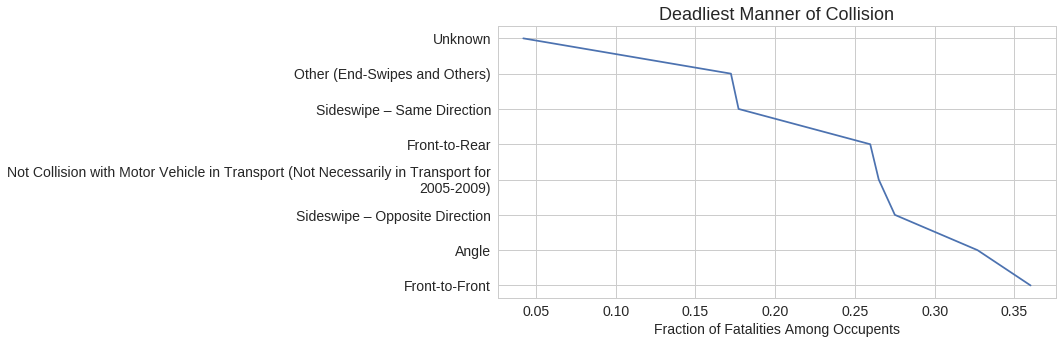

In [0]:
fig = plt.figure(figsize = (10, 5))

plt.plot(type_deadliness["deadliness"],type_deadliness["manner_of_collision_name"])
ax = fig.gca()

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.xlabel("Fraction of Fatalities Among Occupents", fontsize = 14)
plt.title("Deadliest Manner of Collision", fontsize = 18)
plt.show()

Front-to-front collisions are the deadliest vehicle-to-vehicle collisions, and this makes sense. Two cars heading for each other are going to do much more damage than two cars heading away from each other (wait, what?). Below that are angle and sideswipe - opposite direction collisions. This leads me to believe that 'Angle' refers to all collisions in which one car drives into another from neither the front nor the back. Sideswipes can be deadlier, and unsurprisingly, they are more deadly when the cars are traveling in the opposite direction. Unknown is the least deadly, which could be explained by so little damage to the car that investigators were not able to attribute a manner of collision.

### What are the deadliest types of intersections?
Everyone who drives know, intersections are trouble. But are they more trouble than the open road? What about different types of intersections?

In [0]:
%%bigquery --project superb-metric-200303 intersection_deadliness

SELECT a.type_of_intersection , sum( v.fatalities_in_vehicle ) / sum( v.number_of_occupants ) deadliness, count(*) total_vehicles
FROM `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` v,
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a
WHERE v.consecutive_number = a.consecutive_number
GROUP BY a.type_of_intersection
HAVING total_vehicles > 100
ORDER BY deadliness DESC

,type_of_intersection,deadliness,total_vehicles
0,Not an Intersection,0.299915,37441
1,T-Intersection,0.272984,5300
2,Four-Way Intersection,0.229710,9772


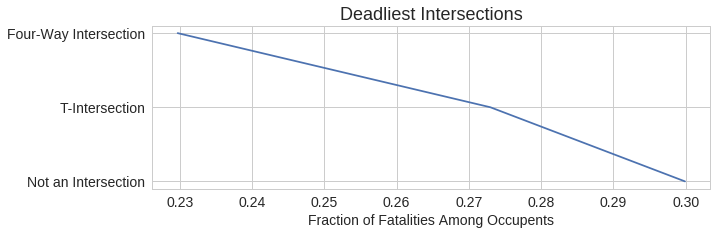

In [0]:
fig = plt.figure(figsize = (10, 3))

plt.plot(intersection_deadliness["deadliness"],intersection_deadliness["type_of_intersection"])
ax = fig.gca()

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.xlabel("Fraction of Fatalities Among Occupents", fontsize = 14)
plt.title("Deadliest Intersections", fontsize = 18)
plt.show()

The deadliest places for drivers are not intersections at all, but the open road, and reasonably so. Drivers move faster on the open road. However what's interesting is that T-intersections are much deadlier than four-way intersections. The explanation for this might be that while there are less lanes entering and exiting a T-intersection, this might make drivers on the continuing road more complacent. Drivers merging onto this road may cause more severe accidents due to continuing drivers considering these intersections more like open roads than places to exercise additional caution when passing. In this same vein, four-way intersections are much more likely to have stop signs or traffic lights for all drivers entering the intersection.

### Where on the trafficway do the deadliest collisions occur?
The environment of a collision can tell us a lot about its severity. Depending on where a collision occurs, many different resulting outcomes are made possible that may dictate the ultimate fate of the motorist.

In [0]:
%%bigquery --project superb-metric-200303 trafficway_deadliness

SELECT a.relation_to_trafficway_name, sum( v.fatalities_in_vehicle ) / sum( v.number_of_occupants ) deadliness, count(*) total_vehicles
FROM `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` v,
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a
WHERE v.consecutive_number = a.consecutive_number
GROUP BY a.relation_to_trafficway_name
HAVING total_vehicles > 100
ORDER BY deadliness DESC

,relation_to_trafficway_name,deadliness,total_vehicles
0,Outside Trafficway,0.682498,770
1,On Roadside,0.627511,11004
2,Separator,0.605263,121
3,On Median,0.509129,1605
4,Gore,0.434932,131
5,On Roadway,0.201244,38128
6,On Shoulder,0.174425,693


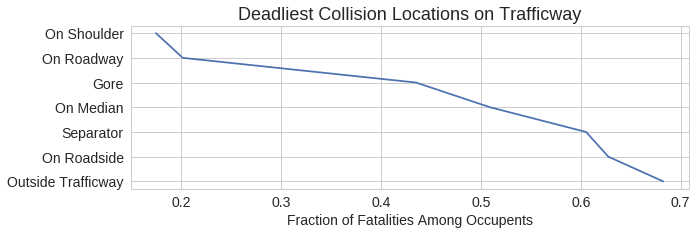

In [0]:
fig = plt.figure(figsize = (10, 3))

plt.plot(trafficway_deadliness["deadliness"],trafficway_deadliness["relation_to_trafficway_name"])
ax = fig.gca()

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.xlabel("Fraction of Fatalities Among Occupents", fontsize = 14)
plt.title("Deadliest Collision Locations on Trafficway", fontsize = 18)
plt.show()

What we are seeing in this visualization makes sense - cars that collide with objects outside of the trafficway are more likely to not survive the collision. These cars are already under extraordinary circumstances to reach objects outside of the trafficway, including much higher speeds, and so this is expected. This explanation also holds for the roadside, the separator, the median, and the gore. Why, then, is the shoulder the only non-roadway location safer than the roadway itself? My guess is that if the collision is being documented as occuring on the shoulder, there is likely to be a concrete traffic barrier in place, which may prevent the car from hitting the deadliest objects away from the roadway. I attempt to confirm this below:

In [0]:
%%bigquery --project superb-metric-200303 _

SELECT a.first_harmful_event_name, count(*) counts
FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a,
  `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` v
WHERE a.consecutive_number = v.consecutive_number
AND a.relation_to_trafficway_name = "On Shoulder"
GROUP BY a.first_harmful_event_name
ORDER BY counts DESC

,first_harmful_event_name,counts
0,Motor Vehicle in Transport,230
1,Parked Motor Vehicle (Not In Transport),181
2,Pedestrian,167
3,Rollover/Overturn,45
4,Pedalcyclist,42
5,Other Object (Not Fixed),9
6,Fell/Jumped from Vehicle,5
7,Working Motor Vehicle,4
8,"Pavement Surface Irregularity (Ruts, Potholes,...",2
9,Curb,2


## Prediction Task - Predicting Fatality in a Single-Driver Traffic Accident

The future of automotive transport is being redefined as autonomous vehicles capture the spotlight. There are still many technological challenges that must be overcome before this new method of transportation becomes ubiquitous, and there will be many expectations for these vehicles to not only replace humans at the wheel, but improve upon their abilitity to sense their environments and make data-driven decisions. No one can be sure how rapidly the rate of traffic accidents will decrease as this transformation takes place, but it is clear that as long as the entire driving force isn't autonomous, we will continue to see accidents occur on our motorways. It will be important for these autonomous vehicles to have some sense of the severity of an accident in terms of its internal occupents given the conditions of a crash. While ideally, sophisticated sensor information will provide a more actionable dataset to learn this severity from, for the early period of autonomous vehicle introduction, no dataset will exist on these relationships. In this section of the analysis, I will attempt to accurately predict the severity of a traffic accident based on conditions of the accident that an autonomous vehicle may reasonably be expected to know. If computed accurately, this information could be transmitted to the relevant authorities instantaneously, giving emergency response services a more accurate idea of what to expect at the scene of the accident. 

### Details of the Data Used for Training

#### Dataset Filtering

For this experiment, we will focus on a specific type of scenario: single occupent cars of a standard make and model with known travel speed and speed limit before the accident during the years 2015 and 2016. We also remove those accidents which result in a fire, since this can act as an additional killer that will be difficult to account for in our model. Below is a list of the conditions we impose through our query:

Feature | Condition
--- | ---
jackknife | "Not an Articulated Vehicle"
gross_vehicle_weight_rating | "Not Applicable"
vehicle_configuration_name | "Not Applicable"
cargo_body_type_name | "Not Applicable"
bus_use | "Not a Bus"
special_use_name | "No Special Use"
emergency_motor_vehicle_use | "Not Applicable"
fire_occurence | "No or Not Reported"
total_lanes_in_roadway | < 8
travel_speed | > 0 and < 998
speed_limit | < 98
hour_of_crash | < 99

This reduces our total possible dataset from 102,192 unique vehicle tuples down to 20,328.

#### Training Label

The label that we will use for this prediction task will be whether or not the single driver survived the accident. Since our target label can take on one of two values, we will use BigQuery's Binary Logistic Regression model to make our predictions. Below is a distribution of our training label in the dataset:

Survived | Died
--- | ---
9,015 | 11,313

This is a fairly even distribution, which will make the model easier to train and evaluate. A label weighting scheme will not need to be implemented, and most evaluation metrics (precision, recall, accuracy, F1) will be fully interpretable.

#### Input Variables

For input variables, we will use many of the variables explored in the previous section, along with a number of additional variables contained in the dataset. For each variable, two justifications will be provided:
* What intuition would suggest that this variable be included in the model?
* Why can we assume that an autonomous vehicle would have this information on hand during an accident?

##### Variables from Previous Section
These variables have already been validated in the previous section, and so I do not repeat the reason why these variables are assumed to be relevant for the model. Only a justification for how they might be collected by an autonomous vehicle is provided.

-------------------

##### Time Columns (Month, Hour)
* Autonomous vehicles will certainly possess the capability to know the month and hour of an accident

##### Environmental Conditions
* Autonomous vehicles will be able to sense the environmental conditions through direct observation of their environment, in addition to real time weather advisories corresponding to their exact GPS coordinates

##### Street Type
* By linking up GPS information with maps information, autonomous vehicles will know what type of roadway they are on at any given moment.

##### Collision Object
* Recent advances in image recognition have given autonomous vehicles the ability to detect and localize objects in their field of vision, which in some cases is a full 360 degrees. 

##### Collision Type (front, side, etc.)
* By combining object localization information and external sensory systems, autonomous vehicles will be able to detect which area of the car has experienced an impact due to collision.

##### Type of Intersection
* Similar to street type, GPS information will help autonomous vehicles understand what sort of intersection they are entering, if entering one at all. Computer vision may assist as well.

##### Collision location on the Trafficway
* One of the systems necessary for autonomous vehicles to be able to safely navigate trafficways is a sensory system that understands where the vehicle is located in relation to the motorway.

##### Light Conditions
* **Justification**: Poorer light conditions may lead to poorer driving and therefore more dangerous accidents
* **Autonomous Vehicles**:  may infer lighting situation using a combination of time tracking and computer vision.

##### Underride / Override
* **Justification**: According to the NHTSA, "An Underride refers to a vehicle sliding under another vehicle during a crash. The classic example is an automobile striking the rear end or the side of a tractor-trailer and coming to a stop under the trailer. In this example, the automobile is the underriding vehicle."
* **Autonomous Vehicles**: may be able to sense when a large vehicle object has passed above or below, but it will have difficulty determining whether the vehicle that is passing is in transport or stationary. For that reason, we have to alter the following values found in the table:

Underride/Override Code | Description
--- | ---
0 | No Underride or Override Noted
1 | Underriding a Motor Vehicle In-Transport, Underride, Compartment Intrusion
2 | Underriding a Motor Vehicle In-Transport, Underride, No Compartment Intrusion
3 | Underriding a Motor Vehicle In-Transport, Underride, Compartment Intrusion Unknown
4 | Underriding a Motor Vehicle Not In-Transport, Underride, Compartment Intrusion
5 | Underriding a Motor Vehicle Not In-Transport, Underride, No Compartment Intrusion
6 | Underriding a Motor Vehicle Not In-Transport, Underride, Compartment Intrusion Unknown
7 | Overriding a Motor Vehicle In-Transport
8 | Overriding a Motor Vehicle Not In-Transport
9 | Unknown if Underride or Override

We remove the distinction between in-transport and not in-transport vehicles by making the following changes:

>* All values of 4 are changed to 1
* All values of 5 are changed to 2
* All values of 6 are changed to 3
* All values of 8 are changed to 7

##### Rollover
* **Justification**: Vehicle rollover is a highly dangerous maneuver that may affect fatality.
* **Autonomous Vehicles**: can use accelerometer data to detect when the vehicle has rolled over, however it would be difficult to detect what caused the rollover. For this reason, the following changes are made to the data:

>* All values of "Rollover, Tripped by Object/Vehicle" are changed to "Rollover, Unknown Type"
* All values of "Rollover, Untripped" are changed to "Rollover, Unknown Type"

##### Travel Speed
* **Justification**: Travel speed is most certainly a contributor to fatality rate in traffic accidents. The faster the vehicle is traveling, the more energy stored in the driver's body that will cause more damage in the event of a collision.
* **Autonomous Vehicles**: can certainly detect their travel speed, as can many non-autonomous cars today can.

##### Total Lanes in Roadway
* **Justification**: The bigger the roadway, the more cars are present, and the more likely a car is to hit other cars versus more dangerous objects far away from the road.
* **Autonomous Vehicles**: will detect the number of lanes using computer vision.

##### Speed Limit
* **Justification**: Speed limit may help the model better understand the context of the road that the accident is occuring on.
* **Autonomous Vehicles**: can detect the speed limit on the road, as many non-autonomous cars do today.

##### Roadway Alignment
* **Justification**: This provides the model with information on the nature of the road that the collision occurred on (e.g. curved left, curved right, straight), and this information may be relevant given that the driver is always on the left side of the car.
* **Autonomous Vehicles**: can detect roadway alignment using computer vision.

##### Roadway Grade
* **Justification**: This feature informs the model about whether the vehicle is traveling up hill, downhill, over a bump, etc, and this may be important for how the car will eventually react when the collision occurs.
* **Autonomous Vehicles**: will be able to detect roadway grade using accelerometers.

##### Roadway Surface Condition
* **Justification**: Whether a roadway is wet, icy, dry, slippery, or in some other condition should help determine what the severity of a collision may be.
* **Autonomous Vehicles**: should be able to derive this information, whether it is from computer vision models, weather data, or sensory systems in the wheels.

### Model Training

#### Create a dataset to store the model

In [0]:
model_dataset_name = 'traffic_fatality'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

#### Train the model

In [0]:
%%bigquery --project superb-metric-200303

CREATE OR REPLACE MODEL `traffic_fatality.single_driver_fatality`
OPTIONS(model_type='logistic_reg'
       ,early_stop = true
       ,auto_class_weights = true) AS
SELECT
  v.fatalities_in_vehicle AS label
  ,v.month_of_crash
  ,v.hour_of_crash 
  ,a.atmospheric_conditions_name 
  ,a.route_signing_name 
  ,a.first_harmful_event_name 
  ,a.manner_of_collision_name 
  ,a.type_of_intersection 
  ,a.relation_to_trafficway_name 
  ,a.light_condition_name
  ,CASE WHEN v.underride_override = 4 THEN 1
        WHEN v.underride_override = 5 THEN 2
        WHEN v.underride_override = 6 THEN 3
        WHEN v.underride_override = 8 THEN 7
        ELSE v.underride_override END AS underride_override
  ,CASE WHEN v.rollover = "Rollover, Tripped by Object/Vehicle" THEN "Rollover, Unknown Type"
        WHEN v.rollover = "Rollover, Untripped" THEN "Rollover, Unknown Type"
        ELSE v.rollover END AS rollover
  ,v.travel_speed
  ,v.total_lanes_in_roadway
  ,v.speed_limit
  ,v.roadway_alignment
  ,v.roadway_grade
  ,v.roadway_surface_condition
FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a,
  `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` v
WHERE a.consecutive_number = v.consecutive_number
  AND number_of_occupants = 1
  AND travel_speed > 0
  AND travel_speed < 998
  AND jackknife = "Not an Articulated Vehicle"
  AND gross_vehicle_weight_rating = "Not Applicable"
  AND vehicle_configuration_name = "Not Applicable"
  AND cargo_body_type_name = "Not Applicable"
  AND bus_use = "Not a Bus"
  AND special_use_name = "No Special Use"
  AND emergency_motor_vehicle_use = "Not Applicable"
  AND fire_occurrence = "No or Not Reported"
  AND total_lanes_in_roadway < 8
  AND speed_limit < 98
UNION ALL
SELECT
  v.fatalities_in_vehicle AS label
  ,v.month_of_crash
  ,v.hour_of_crash 
  ,a.atmospheric_conditions_name 
  ,a.route_signing_name 
  ,a.first_harmful_event_name 
  ,a.manner_of_collision_name 
  ,a.type_of_intersection 
  ,a.relation_to_trafficway_name 
  ,a.light_condition_name
  ,CASE WHEN v.underride_override = 4 THEN 1
        WHEN v.underride_override = 5 THEN 2
        WHEN v.underride_override = 6 THEN 3
        WHEN v.underride_override = 8 THEN 7
        ELSE v.underride_override END AS underride_override
  ,CASE WHEN v.rollover = "Rollover, Tripped by Object/Vehicle" THEN "Rollover, Unknown Type"
        WHEN v.rollover = "Rollover, Untripped" THEN "Rollover, Unknown Type"
        ELSE v.rollover END AS rollover
  ,v.travel_speed
  ,v.total_lanes_in_roadway
  ,v.speed_limit
  ,v.roadway_alignment
  ,v.roadway_grade
  ,v.roadway_surface_condition
FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015` a,
  `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2015` v
WHERE a.consecutive_number = v.consecutive_number
  AND number_of_occupants = 1
  AND travel_speed > 0
  AND travel_speed < 998
  AND jackknife = "Not an Articulated Vehicle"
  AND gross_vehicle_weight_rating = "Not Applicable"
  AND vehicle_configuration_name = "Not Applicable"
  AND cargo_body_type_name = "Not Applicable"
  AND bus_use = "Not a Bus"
  AND special_use_name = "No Special Use"
  AND emergency_motor_vehicle_use = "Not Applicable"
  AND fire_occurrence = "No or Not Reported"
  AND total_lanes_in_roadway < 8
  AND speed_limit < 98
  AND v.hour_of_crash < 99

Executing query with job ID: 5a6ae08d-85ca-4810-8a4d-916b4707fbff
Query executing: 41.45s

ValueError: ignored

### Get Training Statistics

In [0]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `traffic_fatality.single_driver_fatality`)

,training_run,iteration,loss,eval_loss,duration_ms,learning_rate
0,0,5,0.444695,0.451587,2841,3.2
1,0,4,0.458817,0.467083,4382,3.2
2,0,3,0.485522,0.490817,3582,1.6
3,0,2,0.532558,0.535989,3372,0.8
4,0,1,0.593268,0.595039,2988,0.4
5,0,0,0.651487,0.652115,2491,0.2


In [0]:
%%bigquery --project $project_id

# YOUR QUERY HERE
SELECT
    *
FROM
    ML.EVALUATE(MODEL `traffic_fatality.single_driver_fatality`)

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.755399,0.78439,0.732564,0.769621,0.451587,0.842391


It looks like the model was able to predict whether a driver would survive the traffic accident or not with about 73 percent accuracy. Not bad!

### A new test
One way we can evaluate this model is to apply it to the traffic accidents in which vehicles contained more than one person. We can use the count of fatalities again as the target label, by reducing it to the binary task of predicting whether there will be no fatalities or at least one fatality. The model should approximate this label well, since it has learned when an accident is so dangerous as to cause someone to lose their life. Here's the label breakdown:

No deaths | At least one death
--- | ---
3,977 | 5,727

In [0]:

%%bigquery --project $project_id

SELECT
    *
FROM
    ML.EVALUATE(MODEL `traffic_fatality.single_driver_fatality`,
    (SELECT
  CASE WHEN v.fatalities_in_vehicle >= 1 THEN 1
       ELSE 0 END AS label
  ,v.month_of_crash
  ,v.hour_of_crash 
  ,a.atmospheric_conditions_name 
  ,a.route_signing_name 
  ,a.first_harmful_event_name 
  ,a.manner_of_collision_name 
  ,a.type_of_intersection 
  ,a.relation_to_trafficway_name 
  ,a.light_condition_name
  ,CASE WHEN v.underride_override = 4 THEN 1
        WHEN v.underride_override = 5 THEN 2
        WHEN v.underride_override = 6 THEN 3
        WHEN v.underride_override = 8 THEN 7
        ELSE v.underride_override END AS underride_override
  ,CASE WHEN v.rollover = "Rollover, Tripped by Object/Vehicle" THEN "Rollover, Unknown Type"
        WHEN v.rollover = "Rollover, Untripped" THEN "Rollover, Unknown Type"
        ELSE v.rollover END AS rollover
  ,v.travel_speed
  ,v.total_lanes_in_roadway
  ,v.speed_limit
  ,v.roadway_alignment
  ,v.roadway_grade
  ,v.roadway_surface_condition
FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a,
  `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` v
WHERE a.consecutive_number = v.consecutive_number
  AND number_of_occupants > 1
  AND travel_speed > 0
  AND travel_speed < 998
  AND jackknife = "Not an Articulated Vehicle"
  AND gross_vehicle_weight_rating = "Not Applicable"
  AND vehicle_configuration_name = "Not Applicable"
  AND cargo_body_type_name = "Not Applicable"
  AND bus_use = "Not a Bus"
  AND special_use_name = "No Special Use"
  AND emergency_motor_vehicle_use = "Not Applicable"
  AND fire_occurrence = "No or Not Reported"
  AND total_lanes_in_roadway < 8
  AND speed_limit < 98
UNION ALL
SELECT
  CASE WHEN v.fatalities_in_vehicle >= 1 THEN 1
       ELSE 0 END AS label
  ,v.month_of_crash
  ,v.hour_of_crash 
  ,a.atmospheric_conditions_name 
  ,a.route_signing_name 
  ,a.first_harmful_event_name 
  ,a.manner_of_collision_name 
  ,a.type_of_intersection 
  ,a.relation_to_trafficway_name 
  ,a.light_condition_name
  ,CASE WHEN v.underride_override = 4 THEN 1
        WHEN v.underride_override = 5 THEN 2
        WHEN v.underride_override = 6 THEN 3
        WHEN v.underride_override = 8 THEN 7
        ELSE v.underride_override END AS underride_override
  ,CASE WHEN v.rollover = "Rollover, Tripped by Object/Vehicle" THEN "Rollover, Unknown Type"
        WHEN v.rollover = "Rollover, Untripped" THEN "Rollover, Unknown Type"
        ELSE v.rollover END AS rollover
  ,v.travel_speed
  ,v.total_lanes_in_roadway
  ,v.speed_limit
  ,v.roadway_alignment
  ,v.roadway_grade
  ,v.roadway_surface_condition
FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015` a,
  `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2015` v
WHERE a.consecutive_number = v.consecutive_number
  AND number_of_occupants > 1
  AND travel_speed > 0
  AND travel_speed < 998
  AND jackknife = "Not an Articulated Vehicle"
  AND gross_vehicle_weight_rating = "Not Applicable"
  AND vehicle_configuration_name = "Not Applicable"
  AND cargo_body_type_name = "Not Applicable"
  AND bus_use = "Not a Bus"
  AND special_use_name = "No Special Use"
  AND emergency_motor_vehicle_use = "Not Applicable"
  AND fire_occurrence = "No or Not Reported"
  AND total_lanes_in_roadway < 8
  AND speed_limit < 98
  AND v.hour_of_crash < 99))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.749331,0.78191,0.716921,0.765274,0.46349,0.826852


### Conclusion

Nice! We've successfully created a logistic regression model that does an alright job of predicting fatality in traffic accidents across the US. Now, the next task is to implement this sytem in all new autonomous driving vehicles so that these cars can indicate to emergency response units as soon as an accident happens whether the accident was fatal or not with 70-73% accuracy (just kidding - see **Caveat & Limitations**)

Throughout this analysis, we've taken a closer look at traffic accidents in US that end in the worst circumstances - someone losing a life. Through in depth analysis, visualization, and a bit of much needed brevity, we explored how some of these environmental factors can affect the deadliness of traffic accidents. We then used this new knowledge and a bit of additional reasoning to build a predictive model. The model's goal was to leverage many of these envioronmental variables to create an approximation of deadliness, through the task of predicting whether vehicle occupants will live or die. 

#### Caveat & Limitations
So you have an effective prediction model for traffic fatalities, is it time to sound the alarm and send your paper to the New York Times front page? "BOY GENIUS PREDICTS FOR WHOM THE BELL TOLLS!" You certainly could go this route with the models you create, and any journalist you tell about your discoveries will probably find them interesting and applicable. It's our job, however, to prevent the spread of misinformation by being rigorous in our analysis of the limitations of our work. There is one deeply rooted limitation of the work done in this piece: the dataset itself. These vehicles and the accidents they are involved in are only present in the dataset because someone died in the accident. This skews our dataset considerably away from what one would expect in the wild. Many more accidents occur every day that do not result in fatalities, and many of these accidents occur in environmental conditions just as terrible as the ones recorded in our dataset. In the real world, our model would likely sound the fatality alarm much more often than expected of an accurate model. But, in the highly strange case where it is known that at least one fatality has most certainly occurred, our model can at least help decide which vehicle to find them in - if EMS doesn't figure it out first.
